In [60]:
import os
import sys
sys.path.append("../../NephNet")
import argparse
import torch
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from train import get_instance
import numpy as np
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
from torch.optim import lr_scheduler
from tqdm import tqdm
import math
from utils import util
import pandas as pd
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary

print("Modules loaded")

Modules loaded


In [92]:
print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

model_threeD = getattr(module_arch, 'threeDmodel')(num_feature=76, num_classes=9)

# load state dict
resume_threeD = "C:/Users/awoloshu/Documents/NephNet/saved/train44test33/1219_171844/model_best.pth"
checkpoint_threeD = torch.load(resume_threeD)
model_threeD.load_state_dict(checkpoint_threeD['state_dict'])

for param in model_threeD.parameters():
    param.requires_grad = False #change to False

for param in model_threeD.fc7.parameters():
    param.requires_grad = True
for param in model_threeD.fc6.parameters():
    param.requires_grad = True
print("FIN")

model = model_threeD
trainable_params = filter(lambda p: p.requires_grad, model.parameters())


GPUs available: 1
FIN


In [93]:
#Create a data loader for F59
config_text = "C:/Users/awoloshu/Documents/NephNet/configs/config_Train44Test33_transfer.json"
with open(config_text) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

torch.backends.cudnn.benchmark = True
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["NUMEXPR_MAX_THREADS"] = "16"
print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
train_logger = Logger()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# setup data_loader instances
data_loader = get_instance(module_data, 'data_loader', config)
valid_data_loader = data_loader.split_validation()

if torch.cuda.is_available():
    print("Using GPU: " + torch.cuda.get_device_name(0))
else:
    print("Using CPU to train")

# get function handles of loss and metrics
loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
if config['optimizer']['type'] == "adabound":
    optimizer = getattr(adabound, "AdaBound")(trainable_params, **config['optimizer']['args'])
else:
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

trainer = Trainer(model, criterion, metrics, optimizer,
                  resume=None,
                  config=config,
                  data_loader=data_loader,
                  valid_data_loader=valid_data_loader,
                  lr_scheduler=lr_scheduler,
                  train_logger=train_logger)


GPUs available: 1
Using GPU: GeForce RTX 2080 Ti


In [94]:
trainer.train()

    epoch          : 1
    loss           : 1.1228393738468487
    accuracy       : 0.6302083333333334
    f1             : 0.6368893003592587
    balanced_accuracy: 0.6421387631031197
    precision      : 0.6677471522691887
    recall         : 0.6302083333333334
    val_loss       : 1.1077040433883667
    val_accuracy   : 0.6460176991150443
    val_f1         : 0.6464615072541199
    val_balanced_accuracy: 0.6082510082510082
    val_precision  : 0.6740412979351031
    val_recall     : 0.6460176991150443


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/train44test33_transfer\0107_152708\checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 1.1537920435269673
    accuracy       : 0.5755208333333334
    f1             : 0.5804590891261329
    balanced_accuracy: 0.6127073011976393
    precision      : 0.6076088046708488
    recall         : 0.5755208333333334
    val_loss       : 1.0730293989181519
    val_accuracy   : 0.6371681415929203
    val_f1         : 0.6221102158507726
    val_balanced_accuracy: 0.621073371073371
    val_precision  : 0.629079003409807
    val_recall     : 0.6371681415929203


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/train44test33_transfer\0107_152708\checkpoint-epoch2.pth ...
Saving current best: model_best.pth ...
    epoch          : 3
    loss           : 1.0897649923960369
    accuracy       : 0.5833333333333334
    f1             : 0.586085108353255
    balanced_accuracy: 0.5865908856797822
    precision      : 0.6168275369057828
    recall         : 0.5833333333333334
    val_loss       : 1.165052890777588
    val_accuracy   : 0.6194690265486725
    val_f1         : 0.597572076506282
    val_balanced_accuracy: 0.5217583342583342
    val_precision  : 0.6180926916221033
    val_recall     : 0.6194690265486725


Model has not improved in -------------| 1 epochs


    epoch          : 4
    loss           : 1.0788921217123668
    accuracy       : 0.5729166666666666
    f1             : 0.5854033584631795
    balanced_accuracy: 0.5752384487399107
    precision      : 0.6330370613470561
    recall         : 0.5729166666666666
    val_loss       : 1.0729210376739502
    val_accuracy   : 0.6194690265486725
    val_f1         : 0.6100677602995446
    val_balanced_accuracy: 0.5829892329892329
    val_precision  : 0.6340537780803268
    val_recall     : 0.6194690265486725


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/train44test33_transfer\0107_152708\checkpoint-epoch4.pth ...
Saving current best: model_best.pth ...
    epoch          : 5
    loss           : 1.0301318367322285
    accuracy       : 0.5911458333333334
    f1             : 0.6033431454877415
    balanced_accuracy: 0.5864594167044026
    precision      : 0.6539422699810241
    recall         : 0.5911458333333334
    val_loss       : 1.0756453275680542
    val_accuracy   : 0.6460176991150443
    val_f1         : 0.6415147613330223
    val_balanced_accuracy: 0.5785936285936285
    val_precision  : 0.6739831049788321
    val_recall     : 0.6460176991150443


Model has not improved in -------------| 1 epochs


    epoch          : 6
    loss           : 0.9314877440532049
    accuracy       : 0.6953125
    f1             : 0.6964481759156961
    balanced_accuracy: 0.7119268900004307
    precision      : 0.716515402981393
    recall         : 0.6953125
    val_loss       : 0.984937310218811
    val_accuracy   : 0.6637168141592921
    val_f1         : 0.6575730562456226
    val_balanced_accuracy: 0.6040871165871166
    val_precision  : 0.6699001021928869
    val_recall     : 0.6637168141592921


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/train44test33_transfer\0107_152708\checkpoint-epoch6.pth ...
Saving current best: model_best.pth ...
    epoch          : 7
    loss           : 1.1122316320737202
    accuracy       : 0.58984375
    f1             : 0.5940314874240573
    balanced_accuracy: 0.5853710357924699
    precision      : 0.6179735128537042
    recall         : 0.58984375
    val_loss       : 1.0149275064468384
    val_accuracy   : 0.6548672566371682
    val_f1         : 0.6517868482161545
    val_balanced_accuracy: 0.5636146261146261
    val_precision  : 0.6797544510126272
    val_recall     : 0.6548672566371682


Model has not improved in -------------| 1 epochs


    epoch          : 8
    loss           : 0.9530879358450571
    accuracy       : 0.69921875
    f1             : 0.7019426255133522
    balanced_accuracy: 0.6899353775592244
    precision      : 0.7192900259011793
    recall         : 0.69921875
    val_loss       : 1.0694284439086914
    val_accuracy   : 0.6902654867256637
    val_f1         : 0.6734021750611315
    val_balanced_accuracy: 0.6144744144744144
    val_precision  : 0.6945169105615432
    val_recall     : 0.6902654867256637


Model has not improved in -------------| 2 epochs


    epoch          : 9
    loss           : 1.3154028753439586
    accuracy       : 0.5611979166666666
    f1             : 0.5635107293110154
    balanced_accuracy: 0.5605696949188016
    precision      : 0.5878369421247469
    recall         : 0.5611979166666666
    val_loss       : 1.1235359907150269
    val_accuracy   : 0.6637168141592921
    val_f1         : 0.6338878522457226
    val_balanced_accuracy: 0.5809514559514559
    val_precision  : 0.6384281205520144
    val_recall     : 0.6637168141592921


Model has not improved in -------------| 3 epochs


    epoch          : 10
    loss           : 1.3105475107828777
    accuracy       : 0.60546875
    f1             : 0.6205217889050371
    balanced_accuracy: 0.5845227036066988
    precision      : 0.6664994022154674
    recall         : 0.60546875
    val_loss       : 1.124911904335022
    val_accuracy   : 0.6460176991150443
    val_f1         : 0.6282526234669772
    val_balanced_accuracy: 0.5891705516705517
    val_precision  : 0.6424238926393601
    val_recall     : 0.6460176991150443


Model has not improved in -------------| 4 epochs


    epoch          : 11
    loss           : 1.1546667615572612
    accuracy       : 0.546875
    f1             : 0.5650734419613586
    balanced_accuracy: 0.5282042087845966
    precision      : 0.6160661443019445
    recall         : 0.546875
    val_loss       : 1.0334666967391968
    val_accuracy   : 0.6637168141592921
    val_f1         : 0.651885680949491
    val_balanced_accuracy: 0.6348026973026973
    val_precision  : 0.6909689364570201
    val_recall     : 0.6637168141592921


Model has not improved in -------------| 5 epochs


    epoch          : 12
    loss           : 1.3382964928944905
    accuracy       : 0.53515625
    f1             : 0.542260692679139
    balanced_accuracy: 0.5614253780096047
    precision      : 0.5807301049728846
    recall         : 0.53515625
    val_loss       : 1.1304131746292114
    val_accuracy   : 0.6194690265486725
    val_f1         : 0.6216637732706666
    val_balanced_accuracy: 0.5977684352684353
    val_precision  : 0.6630265448589238
    val_recall     : 0.6194690265486725


Model has not improved in -------------| 6 epochs


    epoch          : 13
    loss           : 1.1393253207206726
    accuracy       : 0.5859375
    f1             : 0.6051044664489781
    balanced_accuracy: 0.5997608452633928
    precision      : 0.6665383745172452
    recall         : 0.5859375
    val_loss       : 1.063291311264038
    val_accuracy   : 0.6637168141592921
    val_f1         : 0.6318725825722444
    val_balanced_accuracy: 0.6314717689717689
    val_precision  : 0.644814603234697
    val_recall     : 0.6637168141592921


Model has not improved in -------------| 7 epochs


    epoch          : 14
    loss           : 1.1691522200902302
    accuracy       : 0.6041666666666666
    f1             : 0.6045353559342491
    balanced_accuracy: 0.5945762425244734
    precision      : 0.6365812681242369
    recall         : 0.6041666666666666
    val_loss       : 1.094102382659912
    val_accuracy   : 0.6371681415929203
    val_f1         : 0.6227084615770696
    val_balanced_accuracy: 0.6016858141858141
    val_precision  : 0.6653148036179971
    val_recall     : 0.6371681415929203


Model has not improved in -------------| 8 epochs


    epoch          : 15
    loss           : 1.086675653855006
    accuracy       : 0.6419270833333334
    f1             : 0.6572539774739204
    balanced_accuracy: 0.6646057030489504
    precision      : 0.7105441747165253
    recall         : 0.6419270833333334
    val_loss       : 1.150467872619629
    val_accuracy   : 0.6460176991150443
    val_f1         : 0.6296998074553247
    val_balanced_accuracy: 0.5578185703185703
    val_precision  : 0.6519817145788673
    val_recall     : 0.6460176991150443


Model has not improved in -------------| 9 epochs


    epoch          : 16
    loss           : 1.120400498310725
    accuracy       : 0.5611979166666666
    f1             : 0.5644031077824317
    balanced_accuracy: 0.5693698282600071
    precision      : 0.5869057805110195
    recall         : 0.5611979166666666
    val_loss       : 1.0812135934829712
    val_accuracy   : 0.7079646017699115
    val_f1         : 0.7002173278818142
    val_balanced_accuracy: 0.6411939911939911
    val_precision  : 0.7194368463395012
    val_recall     : 0.7079646017699115


Model has not improved in -------------| 10 epochs


    epoch          : 17
    loss           : 1.079163173834483
    accuracy       : 0.6145833333333334
    f1             : 0.6195627349833096
    balanced_accuracy: 0.6213639755388715
    precision      : 0.642683385010869
    recall         : 0.6145833333333334
    val_loss       : 1.0388436317443848
    val_accuracy   : 0.6991150442477876
    val_f1         : 0.6856170786275483
    val_balanced_accuracy: 0.6209138084138084
    val_precision  : 0.7017033507298994
    val_recall     : 0.6991150442477876


Model has not improved in -------------| 11 epochs


    epoch          : 18
    loss           : 1.0693277021249135
    accuracy       : 0.59765625
    f1             : 0.6035877179757739
    balanced_accuracy: 0.6422514512236505
    precision      : 0.629149345854309
    recall         : 0.59765625
    val_loss       : 1.0773893594741821
    val_accuracy   : 0.6814159292035398
    val_f1         : 0.6531862776187516
    val_balanced_accuracy: 0.6337357087357087
    val_precision  : 0.6674812842527027
    val_recall     : 0.6814159292035398


Model has not improved in -------------| 12 epochs


    epoch          : 19
    loss           : 1.1031189461549122
    accuracy       : 0.6028645833333334
    f1             : 0.6095233647991986
    balanced_accuracy: 0.5995411238882565
    precision      : 0.6351394621676687
    recall         : 0.6028645833333334
    val_loss       : 1.0868362188339233
    val_accuracy   : 0.6637168141592921
    val_f1         : 0.6635340329383066
    val_balanced_accuracy: 0.5909562659562659
    val_precision  : 0.6861222847948512
    val_recall     : 0.6637168141592921


Model has not improved in -------------| 13 epochs


    epoch          : 20
    loss           : 1.142319232225418
    accuracy       : 0.6002604166666666
    f1             : 0.5895093588713841
    balanced_accuracy: 0.5982807467817227
    precision      : 0.6062011952461294
    recall         : 0.6002604166666666
    val_loss       : 1.1506314277648926
    val_accuracy   : 0.6283185840707964
    val_f1         : 0.6226693824038957
    val_balanced_accuracy: 0.5552572427572428
    val_precision  : 0.6390878776219292
    val_recall     : 0.6283185840707964


Model has not improved in -------------| 14 epochs


  0%|          | 0/295 [00:00<?, ?it/s]

prediction percentages
tensor([0.0677, 0.5573, 0.2652, 0.0434, 0.0115, 0.0081, 0.0079, 0.0032, 0.0357])
0


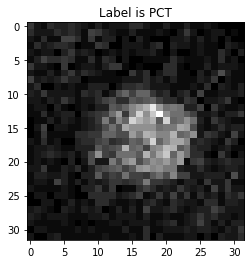

100%|██████████| 295/295 [01:40<00:00,  2.94it/s]


(75345, 2)
TOP 2 ACCURACY: 0.8100338443161458
num test images = 75345
loss = 1.1060
accuracy = 0.6054
f1 = 0.7449
balanced_accuracy = 0.6057
precision = 0.9983
recall = 0.6054
CM will show aggregation of PCT classes
Calculated balanced accuracy after combining PCT: 0.6485485251351677
Confusion matrix, without normalization
[[12569  3508   898   688   182   168    72   530]
 [ 1400  9439   921   578   132   118    18   293]
 [  513   372  3686  1123   193    94    26   151]
 [  662   353  1285  3644   115    43     4    39]
 [  331   266   386   274  7013   520   437  1698]
 [  109   244    45    54   203  3131   728   238]
 [   18    20     4    14   175   738  1633   155]
 [  367   493   285   214  1372   592   648  9123]]


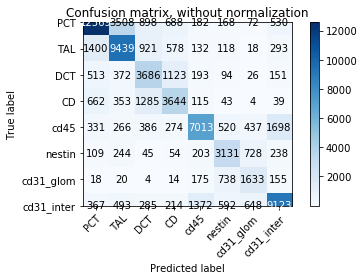

In [95]:
# prepare model for testing
model_threeD = getattr(module_arch, 'threeDmodel')(num_feature=76, num_classes=9)

# load state dict
#resume_threeD = "C:/Users/awoloshu/Documents/NephNet/saved/train44test33/1219_171844/model_best.pth" #0percent
#resume_threeD = "C:/Users/awoloshu/Documents/NephNet/saved/train44test33_transfer/0106_173254/model_best.pth" #10percent
#resume_threeD = "C:/Users/awoloshu/Documents/NephNet/saved/train44test33_transfer/0106_173622/model_best.pth" #5percent
#resume_threeD = "C:/Users/awoloshu/Documents/NephNet/saved/train44test33_transfer/0106_174248/model_best.pth" #20percent
#resume_threeD = "C:/Users/awoloshu/Documents/NephNet/saved/train44test33_transfer/0107_142916/model_best.pth" #7.5%
#resume_threeD = "C:/Users/awoloshu/Documents/NephNet/saved/train44test33_transfer/0107_143718/model_best.pth" #15%
#resume_threeD = "C:/Users/awoloshu/Documents/NephNet/saved/train44test33_transfer/0107_145101/model_best.pth" #5% trial 2
#resume_threeD = "C:/Users/awoloshu/Documents/NephNet/saved/train44test33_transfer/0107_151406/model_best.pth" #2.5% 
resume_threeD = "C:/Users/awoloshu/Documents/NephNet/saved/train44test33_transfer/0107_152708/model_best.pth" #1% 


checkpoint_threeD = torch.load(resume_threeD)
model_threeD.load_state_dict(checkpoint_threeD['state_dict'])
model = model_threeD

data_loader = get_instance(module_data, 'data_loader_test', config)
outputOverlaycsv = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

total_loss = 0.0
metric_fns = metrics
total_metrics = torch.zeros(len(metric_fns))

#classes = ('endothelium', 'pct', 'vasculature')
classes = ('S1', 'PCT', 'TAL', 'DCT', 'CD', 'cd45', 'nestin', 'cd31_glom', 'cd31_inter')
all_pred = []
all_pred_k = []
all_true = []
all_softmax = []

with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(data_loader)):
        k=2
        data, target = data.to(device), target.to(device)
        output = model(data)
        image = np.squeeze(data[0].cpu().data.numpy())
        label = np.squeeze(target[0].cpu().data.numpy())
        all_true.extend(target.cpu().data.numpy())
        all_pred.extend(np.argmax(output.cpu().data.numpy(), axis=1))
        mypred = torch.topk(output, k, dim=1)[1]
        all_pred_k.extend( mypred.cpu().data.numpy())
        m = torch.nn.Softmax(dim=0)
        for row in output.cpu():
            sm = m(row)
            all_softmax.append(sm.data.numpy())

        if i < 1:
            m = torch.nn.Softmax(dim=0)
            print("prediction percentages")
            print(m(output.cpu()[0]))
            print(all_true[i])
            plt.figure()
            plt.imshow(image[3], cmap = 'gray')
            plt.title("Label is " + classes[np.argmax(m(output.cpu()[0]))])
            plt.pause(0.1)

            #all_softmax.extend(m(output.cpu()))
        #
        # save sample images, or do something with output here
        #

        # computing loss, metrics on test set
        loss = criterion(output, target)
        batch_size = data.shape[0]
        total_loss += loss.item() * batch_size
        for i, metric in enumerate(metric_fns):
            total_metrics[i] += metric(output.cpu(), target.cpu()) * batch_size

    correct = 0
    all_pred_k = np.array(all_pred_k)
    print(all_pred_k.shape)
    all_pred_k = torch.from_numpy(all_pred_k)
    all_true_k = torch.from_numpy(np.array(all_true))
    for i in range(k):
        correct += torch.sum(all_pred_k[:, i] == all_true_k).item()
    print("TOP 2 ACCURACY: {}".format(correct / len(all_true)))   
    
if outputOverlaycsv:
    ids = data_loader.dataset.getIds()
    softmax = pd.DataFrame(all_softmax)
    #ids = ids[:,1].reshape(ids.shape[0], 1)
    num_test = len(all_true)
    ids = ids[:num_test]
    print(ids[0:5])
    print(ids.shape)
    print(softmax.shape)
    print(len(all_true))
    frames = [ids, softmax, pd.DataFrame(all_true)]
    output_data= np.concatenate(frames, axis=1)
    print(output_data.shape)
    output_df = pd.DataFrame(output_data)
    filename = "overlaycsv_" + config['name'] + ".csv"
    output_df.to_csv(filename, index=False,  header=False)

n_samples = len(data_loader.sampler)
print("num test images = " + str(n_samples))
log = {'loss': total_loss / n_samples}
log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
for key in log:
    print("{} = {:.4f}".format(key, log[key]))
#print(log)
log['classes'] = classes
log['test_targets'] = all_true
log['test_predictions'] = all_pred
print("CM will show aggregation of PCT classes")

util.plot_confusion_matrix_combinePCT(all_true, all_pred, classes=classes, normalize=False)